## Exploring information from student grades in 902, 10th, and 11th grade.

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import janitor
import re
from pathlib import Path
from utils.pipeline import remove_unregistered_students, retrieve_grade_reports
warnings.filterwarnings('ignore')

# # Machine Learning libraries
# from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.linear_model import LogisticRegression

# # MLflow for experiment tracking
# import mlflow
# import mlflow.sklearn
# from mlflow.models import infer_signature
# from mlflow.tracking import MlflowClient


## 1. Exploring data.

In [2]:
base = Path("./cleaned_data")
paths = sorted(base.glob("*.parquet"))

In [3]:
dfs = {p.stem : pd.read_parquet(p) for p in paths}

In [4]:
noveno_2 = {}
decimo_1 = {}
decimo_2 = {}
decimo_3 = {}
decimo_4 = {}
once_1 = {}
once_2 = {}
once_3 = {}


for name, df in dfs.items():
    if name.startswith("10_1"):
        decimo_1[name] = df
    elif name.startswith("10_2"):    
        decimo_2[name] = df
    elif name.startswith("10_3"):    
        decimo_3[name] = df
    elif name.startswith("10_4"):
        decimo_4[name] = df
    elif name.startswith("11_1"):
        once_1[name] = df
    elif name.startswith("11_2"):
        once_2[name] = df
    elif name.startswith("11_3"):
        once_3[name] = df
    elif name.startswith("9_2"):
        noveno_2[name] = df

#### 1.1 Cleaning dataset

In [5]:
noveno_2['9_2_1'].columns

Index(['Competencia', 'CONOCER', 'HACER', 'SER', 'CONVIVIR', 'Subtotal NIVEL',
       'Nota P1', 'Rec P1', 'Nota P2', 'Rec P2', 'Nota P3', 'Rec P3',
       'Nota PF', 'Rec PF', 'OBS  1', 'OBS  2', 'OBS  3', 'OBS  4', 'OBS  5',
       'LLEGADA TARDE', 'INASISTENCIA JUSTIFICADA',
       'INASISTENCIA INJUSTIFICADA', 'PERMISO', 'RETARDO'],
      dtype='object')

Columns to drop:

* `Competencia`
* `OBS n` where n = 1, 2, 3, 4, 5
* `Nota P3`,
* `Rec P3`,
* `Rec PF`

### 1.2 Analysing student cumulated grades in Chemistry.

In [6]:
to_analyse = {
    i: remove_unregistered_students(dfs[k])['Nota PF'].value_counts().reset_index()
    for i, k in enumerate(dfs)
    if i % 2 == 0    
}

In [7]:
order = ["S", "A", "B", "b"]
cat_cols = ['CONOCER', 'HACER', 'SER', 'CONVIVIR', 'Subtotal NIVEL', 'Nota P1', 'Nota P2', 'Nota P3', 'Nota PF']
dfs['10_1_1'][cat_cols] = dfs['10_1_1'][cat_cols].replace(
        {"None" : pd.NA, "": pd.NA}
    ).apply(
        lambda s: s.str.strip() if s.dtype =="object" else s
    ).apply(
        lambda s : pd.Categorical(s, categories=order, ordered=True)
    )

In [8]:
to_analyse[4].sort_values(by='Nota PF')

,Nota PF,count
1,S,9
0,A,24
2,B,6
3,b,1


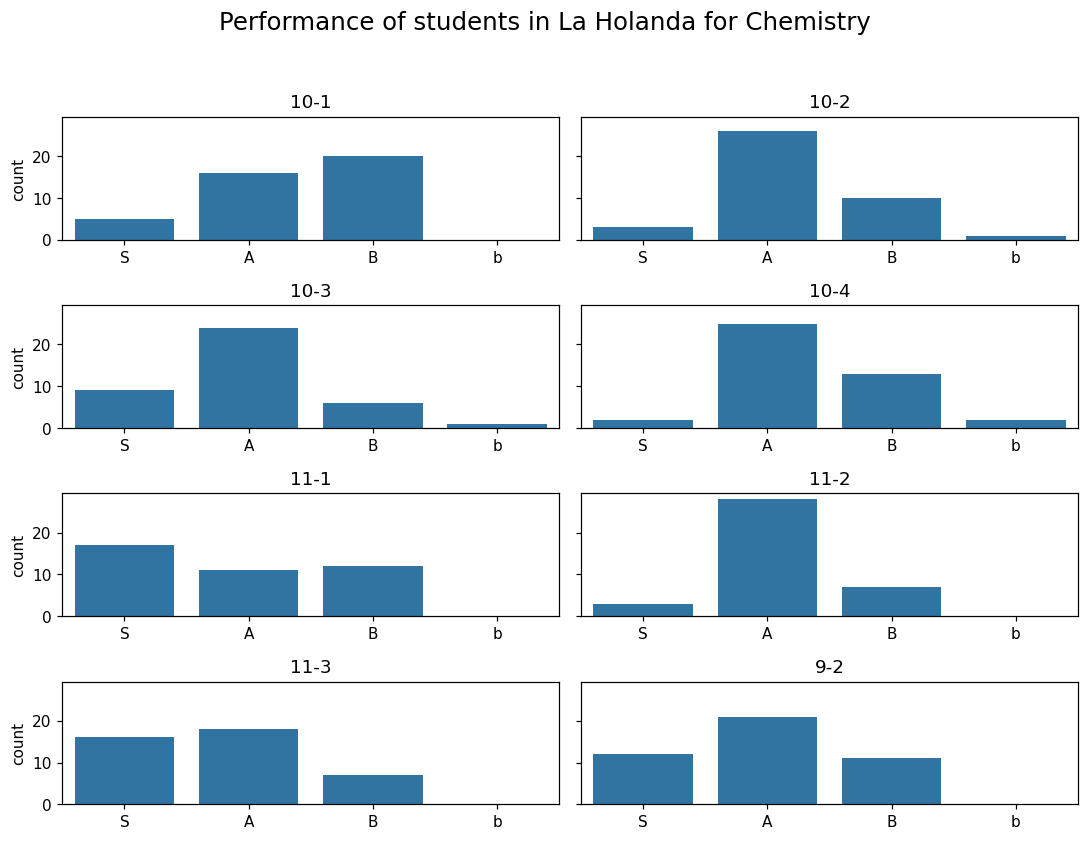

In [9]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 8), dpi=110, sharex=False, sharey=True)

# Set a single title for the whole figure
fig.suptitle("Performance of students in La Holanda for Chemistry", fontsize=16)

# Plot the first 6 series from to_analyse into the 3x2 grid
for ax, series in zip(axes.flatten(), to_analyse.values()):
	sns.barplot(x=series['Nota PF'], y=series['count'], ax=ax)
	ax.set_xlabel("")
	ax.set_ylabel("count")
 
axes.flatten()[0].set_title("10-1")
axes.flatten()[1].set_title("10-2")
axes.flatten()[2].set_title("10-3")
axes.flatten()[3].set_title("10-4")
axes.flatten()[4].set_title("11-1")
axes.flatten()[5].set_title("11-2")
axes.flatten()[6].set_title("11-3")
axes.flatten()[7].set_title("9-2")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [10]:
titles = ["10-1", "10-2", "10-3", "10-4", "11-1", "11-2", "11-3", "9-2"]
grades_analysis_for_all_courses = {
    key: grades.rename(
        columns={
            "Nota PF" : f"nota_pf_{key}",
            "count" : f"count_for_{key}"
            }
        ).sort_values(
            by=f"nota_pf_{key}",
            ascending=False
        )
    for key, grades in zip(titles, to_analyse.values())
}

In [11]:
concat_analysis = pd.concat(objs=grades_analysis_for_all_courses.values(), axis=1, ignore_index=True)

In [12]:
concat_analysis.drop(columns=np.arange(2, 15, 2), inplace=True)

In [13]:
concat_analysis = concat_analysis.rename(
    columns={
        0:"nota_pf",
        1:"10_1",
        3:"10_2",
        5:"10_3",
        7:"10_4",
        9:"11_1",
        11:"11_2",
        13:"11_3",
        15:"9_2"
    }
)

concat_analysis.sort_values(by='nota_pf', ascending=False, inplace=True)

In [14]:
proportion_concat = concat_analysis.copy()

# Proportion for 10th levels.
proportion_concat['10'] = proportion_concat[['nota_pf', '10_1', '10_2', '10_3', '10_4']].sum(axis=1, numeric_only=True)
proportion_concat['10'] *= (1/proportion_concat['10'].sum()) * 100
proportion_concat.drop(columns=['9_2','10_1', '10_2', '10_3', '10_4'], inplace=True)

# Proportion for 11th levels.
proportion_concat['11'] =proportion_concat[['nota_pf', '11_1', '11_2', '11_3']].sum(axis=1, numeric_only=True)
proportion_concat['11'] *= (1/proportion_concat['11'].sum()) * 100
proportion_concat.drop(columns=['11_1', '11_2', '11_3'], inplace=True)

In [15]:
melted_concat_analysis = concat_analysis.melt(
    id_vars='nota_pf',
    var_name='group'
)

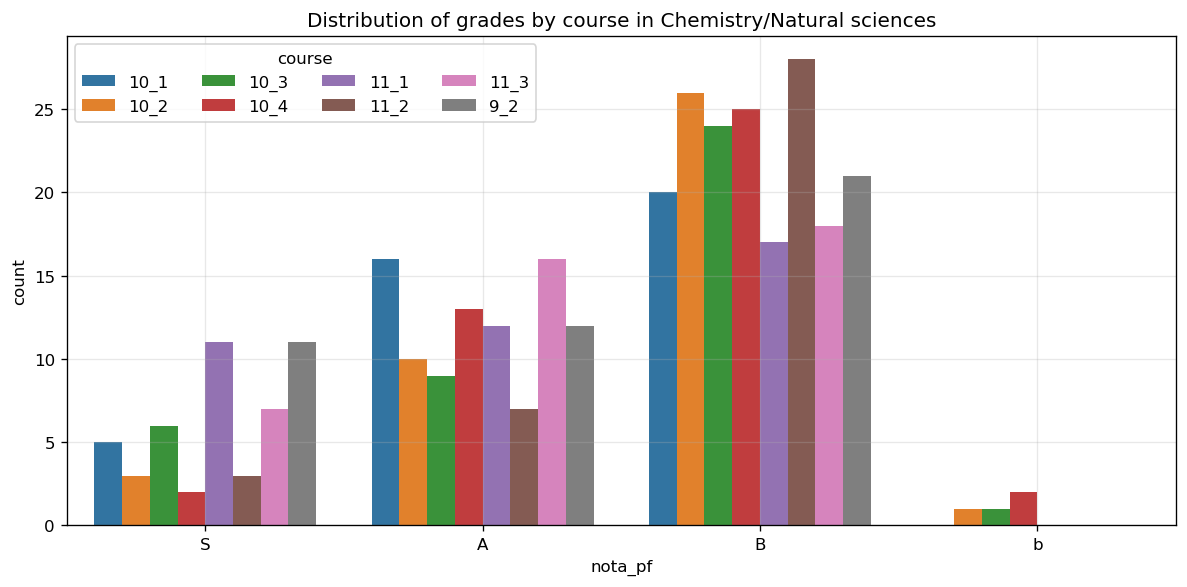

In [16]:
plt.figure(figsize=(10,5), dpi=120)
sns.barplot(data=melted_concat_analysis, x='nota_pf', y='value', hue='group', order=order)
plt.title('Distribution of grades by course in Chemistry/Natural sciences')
plt.xlabel('nota_pf')
plt.ylabel('count')
plt.legend(title='course', ncol=4)   # tidy legend
plt.tight_layout()
plt.grid(alpha=2/7)
plt.show()

In [17]:
proportion_concat

,nota_pf,10,11
3,b,2.453988,0.000000
0,B,58.282209,52.941176
1,A,29.447853,29.411765
2,S,9.815951,17.647059


In [18]:
proportion_concat.melt(id_vars='nota_pf', var_name='group')

,nota_pf,group,value
0,b,10,2.453988
1,B,10,58.282209
2,A,10,29.447853
3,S,10,9.815951
4,b,11,0.000000
5,B,11,52.941176
6,A,11,29.411765
7,S,11,17.647059


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


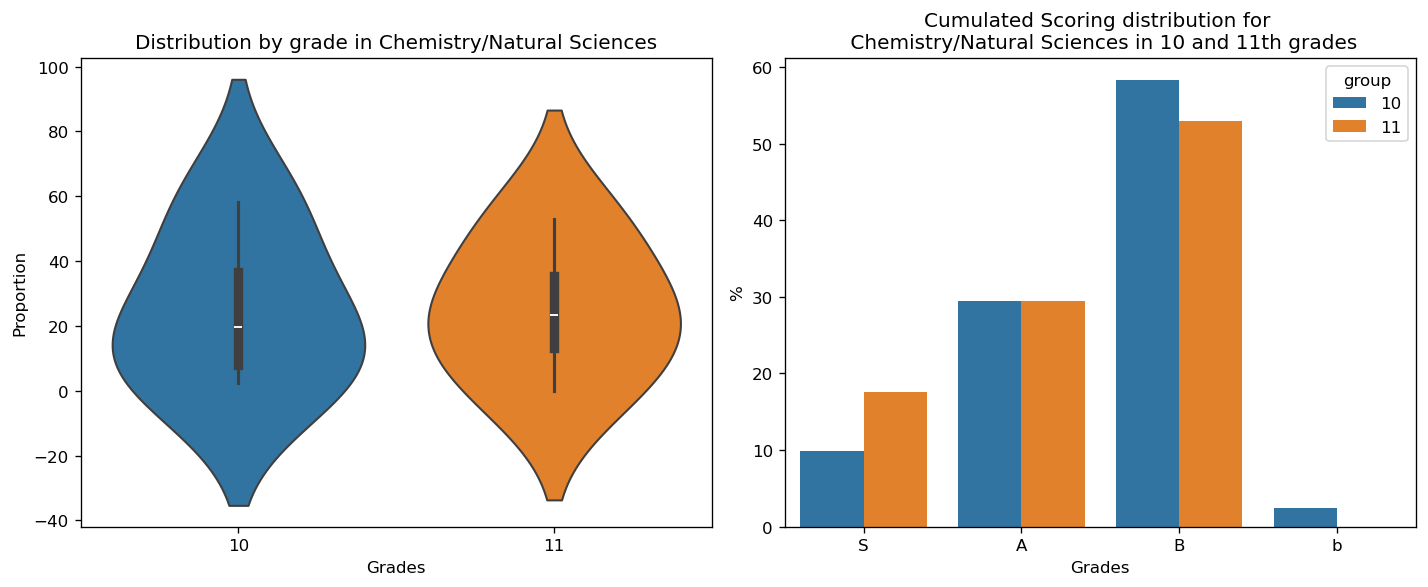

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=120)
sns.violinplot(
    data=proportion_concat,
    ax=ax1
    # order=order
)
sns.barplot(
    data=proportion_concat.melt(id_vars='nota_pf', var_name='group'),
    x='nota_pf',
    y='value',
    hue='group',
    ax=ax2,
)

ax1.set_title('Distribution by grade in Chemistry/Natural Sciences')
ax1.set_xlabel('Grades')
ax1.set_ylabel('Proportion')

ax2.set_title('Cumulated Scoring distribution for \n Chemistry/Natural Sciences in 10 and 11th grades')
ax2.set_xlabel('Grades')
ax2.set_ylabel('%')

plt.tight_layout()
plt.show()

### 1.3 Cleaning data from cumulated grades in math and spanish.

*1.3.1: Reading individual files for 9*

In [20]:
path_for_9_2 = Path('./consolidados/consolidado_902.xls')
path_for_10_1 = Path('./consolidados/consolidado_1001.xls')
path_for_10_2 = Path('./consolidados/consolidado_1002.xls')
path_for_10_3 = Path('./consolidados/consolidado_1003.xls')
path_for_10_4 = Path('./consolidados/consolidado_1004.xls')
path_for_11_1 = Path('./consolidados/consolidado_1101.xls')
path_for_11_2 = Path('./consolidados/consolidado_1102.xls')
path_for_11_3 = Path('./consolidados/consolidado_1103.xls')

In [21]:
tables_from_9_2 = pd.read_html(
    path_for_9_2,
    attrs={"id" : "consolidadonotas_periodo_tabla"}
)

In [22]:
df_9_2 = tables_from_9_2[0]

In [23]:
if isinstance(df_9_2.columns, pd.MultiIndex):
    df_9_2.columns = df_9_2.columns.get_level_values(-1)

In [24]:
final_student_9_2 = 95 # Automate this depends heavily on assigning a final_student number.

In [25]:
df_9_2.loc[:final_student_9_2, :].columns

Index(['Codigo', 'No Lista', 'Nombre', 'Periodo', 'ESP', 'INGL', 'EDUFI',
       'ART', 'SOC', 'ERE', 'MAT', 'NAT', 'TECN', 'ESC.PAD', 'COMPO',
       'Electiva', 'Electiva.1', 'S', 'A', 'B', 'b'],
      dtype='object')

In [26]:
# Cleaning noveno_2_notas

noveno_2_notas = df_9_2.loc[:final_student_9_2, ['Codigo', 'Nombre', 'ESP', 'MAT']]

noveno_2_notas = noveno_2_notas.dropna(
    axis=0, 
    subset=noveno_2_notas.columns[2:], 
    how='any'
).reset_index().clean_names(
    case_type='snake',
    strip_underscores=True,
    remove_special=True
).rename(columns={'index':'idx'})

noveno_2_notas_p1 = noveno_2_notas[noveno_2_notas['idx'] %2 == 0]
noveno_2_notas_p2 = noveno_2_notas[noveno_2_notas['idx'] %2 != 0]

In [27]:
# Removing retired students.
noveno_2_notas_p1 = noveno_2_notas_p1[~noveno_2_notas_p1['idx'].isin([16, 28, 40, 70])]

In [28]:
# Join by idx.

noveno_2_notas_p2['idx'] -= 1

noveno_2_notas_p2 = noveno_2_notas_p2.merge(
    noveno_2_notas_p1,
    on='idx',
    how='inner',
    suffixes=("_p2", "_p1")
)[['idx', 'codigo_p1', 'nombre_p1', 'esp_p2', 'mat_p2']].rename(
    columns={
        'codigo_p1' : 'codigo',
        'nombre_p1' : 'nombre',
        'esp_p2' : 'esp',
        'mat_p2' : 'mat'
    }
)

In [29]:
noveno_2_notas_p1.tail()

,idx,codigo,nombre,esp,mat
80,84,2122.0,SÁNCHEZ GUZMÁN DANNA NICOLE,A,B
82,86,1170.0,SUAREZ CAICEDO ANGEL STEBAN,A,A
84,88,2082.0,SUAREZ CORTES LAURA MICHEL,B,B
86,90,1120.0,VARON GUTIERREZ NIKOL,B,B
88,94,2138.0,PINZON ROMAN ERID DANIEL,B,B


In [30]:
noveno_2_notas_p2.tail()

,idx,codigo,nombre,esp,mat
37,84,2122.0,SÁNCHEZ GUZMÁN DANNA NICOLE,B,B
38,86,1170.0,SUAREZ CAICEDO ANGEL STEBAN,B,B
39,88,2082.0,SUAREZ CORTES LAURA MICHEL,b,b
40,90,1120.0,VARON GUTIERREZ NIKOL,B,B
41,94,2138.0,PINZON ROMAN ERID DANIEL,B,B


*1.3.2: Reading individual files for 10*

*1.3.2.1 : 10.1*

In [31]:
path_for_10_1.exists()

True

In [32]:
tables_from_10_1 = pd.read_html(
    path_for_10_1,
    attrs={"id" : "consolidadonotas_periodo_tabla"}
)

In [33]:
df_10_1 = tables_from_10_1[0]

In [34]:
if isinstance(df_10_1.columns, pd.MultiIndex):
    df_10_1.columns = df_10_1.columns.get_level_values(-1)
    print("Is Instance")

Is Instance


In [35]:
final_student_10_1 = 82 # Automate this depends heavily on assigning a final_student number.

In [36]:
df_10_1.iloc[:final_student_10_1, :].tail(2)

,Codigo,No Lista,Nombre,Periodo,LECT,ESP,MAT,ECON,INGL,NAT,...,ERE,EDUFI,TECN,ESC.PAD,COMPO,Electiva,S,A,B,b
80,192.0,41.0,ZAMUDIO VEGA NICOLL MISHELL,P1,B,B,b,b,B,A,...,B,A,b,S,A,B AGROP,1.0,6.0,5.0,3.0
81,NaN,NaN,NaN,P2,b,b,b,b,b,B,...,B,b,b,b,B,b AGROP,0.0,0.0,5.0,10.0


In [37]:
# Cleaning decimo_1_notas

decimo_1_notas = df_10_1.loc[:final_student_10_1, ['Codigo', 'Nombre', 'ESP', 'MAT']]

decimo_1_notas = decimo_1_notas.dropna(
    axis=0, 
    subset=decimo_1_notas.columns[2:], 
    how='any'
).reset_index().clean_names(
    case_type='snake',
    strip_underscores=True,
    remove_special=True
).rename(columns={'index':'idx'})

decimo_1_notas_p1 = decimo_1_notas[decimo_1_notas['idx'] %2 == 0]
decimo_1_notas_p2 = decimo_1_notas[decimo_1_notas['idx'] %2 != 0]

In [38]:
decimo_1_notas_p2['idx'] -= 1

decimo_1_notas_p2 = decimo_1_notas_p2.merge(
    decimo_1_notas_p1,
    on='idx',
    how='inner',
    suffixes=("_p2", "_p1")
)[['idx', 'codigo_p1', 'nombre_p1', 'esp_p2', 'mat_p2']].rename(
    columns={
        'codigo_p1' : 'codigo',
        'nombre_p1' : 'nombre',
        'esp_p2' : 'esp',
        'mat_p2' : 'mat'
    }
)

*1.3.2.2 : 10.2*

In [39]:
path_for_10_2.exists()

True

In [40]:
tables_from_10_2 = pd.read_html(
    path_for_10_2,
    attrs={"id" : "consolidadonotas_periodo_tabla"}
)

In [41]:
df_10_2 = tables_from_10_2[0]
if isinstance(df_10_2.columns, pd.MultiIndex):
    df_10_2.columns = df_10_2.columns.get_level_values(-1)
    print("En efecto Rick, Is Instance")

En efecto Rick, Is Instance


In [42]:
final_student_10_2 = 81 # Automate this depends heavily on assigning a final_student number.

In [43]:
df_10_2.iloc[:final_student_10_2, :].tail(2)

,Codigo,No Lista,Nombre,Periodo,LECT,ESP,MAT,ECON,INGL,NAT,...,ERE,EDUFI,TECN,ESC.PAD,COMPO,Electiva,S,A,B,b
79,NaN,NaN,NaN,P2,B,B,A,B,b,A,...,B,B,S,b,B,b CONSERV,1.0,4.0,7.0,3.0
80,2052.0,41.0,VILLAMIZAR CARDENAS JUAN SEBASTIAN,P1,B,B,S,B,B,A,...,B,S,B,S,A,S CONSERV,4.0,4.0,7.0,0.0


In [44]:
df_10_2['Nombre'] = df_10_2['Nombre'].astype('str')

In [45]:
indexes_to_drop = df_10_2[df_10_2['Nombre'].apply(
    lambda x: bool(re.search(r"\t", x))
)].index.to_list()

indexes_to_drop

[30, 70]

In [46]:
df_10_2.drop(index=indexes_to_drop, axis=0, inplace=True)

In [47]:
df_10_2.clean_names(
    case_type='snake',
    strip_underscores=True,
    remove_special=True
).columns

Index(['codigo', 'no_lista', 'nombre', 'periodo', 'lect', 'esp', 'mat', 'econ',
       'ingl', 'nat', 'fis', 'filo', 'poli', 'ere', 'edufi', 'tecn', 'esc_pad',
       'compo', 'electiva', 's', 'a', 'b', 'b'],
      dtype='object')

In [48]:
['codigo', 'no_lista', 'nombre', 'periodo', 'lect', 'esp', 'mat', 'econ', 'ingl', 'nat', 'fis', 'filo', 'poli', 'ere', 'edufi', 'tecn', 'compo', 'electiva']

['codigo',
 'no_lista',
 'nombre',
 'periodo',
 'lect',
 'esp',
 'mat',
 'econ',
 'ingl',
 'nat',
 'fis',
 'filo',
 'poli',
 'ere',
 'edufi',
 'tecn',
 'compo',
 'electiva']

In [49]:
# Cleaning decimo_1_notas

decimo_2_notas = df_10_2.loc[:final_student_10_2, ['Codigo', 'Nombre', 'ESP', 'MAT']]

decimo_2_notas = decimo_2_notas.dropna(
    axis=0, 
    subset=decimo_2_notas.columns[2:], 
    how='any'
).reset_index().clean_names(
    case_type='snake',
    strip_underscores=True,
    remove_special=True
).rename(columns={'index':'idx'})

decimo_2_notas_p1 = decimo_2_notas[decimo_2_notas['idx'] %2 == 0]
decimo_2_notas_p2 = decimo_2_notas[decimo_2_notas['idx'] %2 != 0]

In [50]:
decimo_2_notas_p2['idx'] -= 1

decimo_2_notas_p2 = decimo_2_notas_p2.merge(
    decimo_2_notas_p1,
    on='idx',
    how='inner',
    suffixes=("_p2", "_p1")
)[['idx', 'codigo_p1', 'nombre_p1', 'esp_p2', 'mat_p2']].rename(
    columns={
        'codigo_p1' : 'codigo',
        'nombre_p1' : 'nombre',
        'esp_p2' : 'esp',
        'mat_p2' : 'mat'
    }
)

In [51]:
decimo_2_notas_p2

,idx,codigo,nombre,esp,mat
0,0,1.0,AGUILAR MORALES ESTEBAN,B,b
1,2,2058.0,ARCILA GUTIERREZ MANUEL DAVID,A,S
2,4,2020.0,ARREDONDO DAZA KEVIN SANTIAGO,A,S
3,6,2056.0,CAMACHO MENDEZ JUAN JOSE,A,S
4,8,1453.0,CARDONA ARANGO BELKY SARITA,B,b
5,10,2023.0,CARVAJAL RODRIGUEZ FREIDER JULIAN,B,A
6,12,2088.0,CASTRILLON CAMARGO SEBASTIAN,A,S
7,14,2083.0,CHAVES VILLEGAS MAIRA FERNANDA,A,A
8,16,1062.0,CONTRERAS HERNANDEZ JUAN SEBASTIAN,b,A
9,18,11.0,DIAZ RODRIGUEZ JUAN DAVID,A,S


*1.3.2.3: 10.3*

In [53]:
retrieve_grade_reports('./consolidados/consolidado_1003.xls', final_student=85)["p1"]

,idx,codigo,no_lista,nombre,periodo,lect,esp,mat,econ,ingl,nat,fis,filo,poli,ere,edufi,tecn,compo
0,0,1446.0,1.0,AGUIRRE GELACIO DANNA SOFIA,P1,b,B,B,A,B,A,A,B,B,A,A,S,A
2,2,1209.0,2.0,ALFONSO CASTAÑEDA JOHAN SANTIAGO,P1,B,B,B,B,B,A,A,B,A,B,A,S,S
4,4,2.0,3.0,AMAYA GARCIA IONA VALENTINA,P1,B,B,A,A,A,B,A,B,A,B,A,b,S
6,6,1527.0,4.0,AVENDAÑO PIRAQUIVE JUAN CAMILO,P1,B,A,S,B,S,S,A,A,A,B,S,S,S
8,8,2021.0,5.0,AVILA PETE DANNA SHIRLEY,P1,B,B,b,B,B,A,A,S,A,B,A,S,S
10,10,1056.0,6.0,AYALA TORRES CÉSAR ALEXANDER,P1,B,A,S,B,B,A,A,A,A,A,A,S,S
12,12,141.0,7.0,BELTRAN TRIANA ANGEL GABRIEL,P1,A,B,B,B,B,B,A,B,A,B,S,A,S
14,14,1114.0,8.0,BORJA PEDREROS SAMUEL,P1,B,A,S,S,S,S,A,B,A,B,A,S,S
16,16,6.0,9.0,CAMARGO GUTIERREZ KEINNER DAVID,P1,B,B,A,B,A,B,A,B,B,B,A,B,A
18,18,928.0,10.0,CASTRO CASTRO ANYELA YISETH,P1,B,S,A,B,S,A,A,B,B,B,B,S,S


### 2.4 Analysing student cumulated grades in math and spanish.